<a href="https://colab.research.google.com/github/componavt/sns4human/blob/main/src/vk/nlp/scikit_learn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import requests
filename = 'state_tokens.csv'
response = requests.get(f'https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/data/vk/posts/topics/{filename}')
with gzip.GzipFile(fileobj=BytesIO(response.content), mode='rb') as f:
    tokens = pd.read_csv(f, delimiter=',', encoding='utf-8')['tokens']

In [ ]:
import nltk
import requests
from nltk.tokenize import word_tokenize
!pip install -U pymorphy3
import pymorphy3
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
from nltk.corpus import stopwords
stop_words = stopwords.words("russian")
stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/RussianStopWords.txt').text.split('\n')
stop_words += requests.get('https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/src/vk/nlp/stopwords-ru.txt').text.split()
alphabet = set('абвгдеёжзийклмнопрстуфхцчшщъыьэюя-')
morph = pymorphy3.MorphAnalyzer(lang='ru')

In [ ]:
!pip install pymorphy3
import pymorphy3
morph = pymorphy3.MorphAnalyzer(lang='ru')

def process_text(text):
    check_hash = False
    processed_parts = []
    for w in nltk.word_tokenize(text):
      if len(w) == 1:
        continue
      w_tag = morph.parse(w.strip())[0].tag
      if set(w.lower()).issubset(alphabet):
        if w.isalpha() and w.lower():
          if w.isupper() and len(w) <= 3:
              processed_parts.append(w)
          else:
              res = morph.parse(w.lower())[0].normal_form
              if res not in stop_words:
                  processed_parts.append(res)
    result = ' '.join(processed_parts)
    return str(result)

for index, row in df.iterrows():
    text = row['text'].lower()
    df.loc[index, 'normalized'] = process_text(row['text'].lower())


In [ ]:
from sklearn.model_selection import train_test_split
train_docs, test_docs = train_test_split(df, test_size=0.2, random_state=42, shuffle=True) # посчитать точность на тестовой сотне

In [ ]:
unique_topics = train_docs['topic'].unique()
len(unique_topics)

27

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import joblib
# Создаем векторizer
vectorizer = TfidfVectorizer(max_df=.2, min_df=3, max_features=2000)

# Преобразуем текст в матрицу
doc_train_matrix = vectorizer.fit_transform(train_docs['normalized'])

# Получаем названия признаков (слов)
words = vectorizer.get_feature_names_out()  # Используем get_feature_names_out()

doc_test_matrix = vectorizer.transform(test_docs['normalized'])
topic_labels = ['Тема {}'.format(i) for i in range(1, 28)]

lda = LatentDirichletAllocation(n_components=27, n_jobs=-1, max_iter=500,
                                learning_method='batch', evaluate_every=5,
                                verbose=1, random_state=42)
lda.fit(doc_train_matrix)



joblib.dump(lda, 'model.pkl')  # Сохранение модели
lda = joblib.load('model.pkl')  # Загрузка модели

topics_count = lda.components_
topics_prob = topics_count / topics_count.sum(axis=1).reshape(-1, 1)
topics = pd.DataFrame(topics_prob.T,
                      index=words,
                      columns=topic_labels)
topics.head()

In [ ]:
n_words = 12
top_words = {}
for topic, words_ in topics.items():
    top_words[topic] = words_.nlargest(n_words).index.tolist()
pd.DataFrame(top_words)

,Тема 1,Тема 2,Тема 3,Тема 4,Тема 5,Тема 6,Тема 7,Тема 8,Тема 9,Тема 10,...,Тема 18,Тема 19,Тема 20,Тема 21,Тема 22,Тема 23,Тема 24,Тема 25,Тема 26,Тема 27
0,олонец,тест,фестиваль,конкурс,память,калевала,творчество,пример,сладкий,печь,...,музей,памятник,игрушка,издать,калевала,калитка,карел,река,район,ялюблюэтотвашпетрозаводск
1,озеро,конкк,коллектив,организация,сказка,фотография,народный,язык,начаться,пряжинский,...,выставка,калитка,зал,победа,водопад,комиссия,ягода,тверской,сутки,молоко
2,вспомнить,акция,искусство,общественный,загадка,художник,культура,опубликовать,знаток,май,...,национальный,театр,программа,рунопевец,эпос,берёза,ухо,добрый,пудожский,предприниматель
3,администрация,замечательный,детский,региональный,пословица,близкий,информационный,стена,постановка,эссойло,...,культура,спектакль,пирог,образ,песня,дорожный,поэт,лёд,черника,профессионал
4,онежский,завтра,хор,заявка,гореть,кижи,культурный,неделя,музей,экспозиция,...,история,интересно,клуб,изба,художественный,участок,хозяйка,спешить,деревня,президент
5,посёлок,уходить,мероприятие,традиция,поговорка,млн,выпуск,месяц,музыкант,съезд,...,участие,гордость,петрозаводский,погружать,скала,избирательный,тест,класс,мероприятие,гдепоестьпетрозаводск
6,линия,возможность,сосновый,сайт,тепло,бюджет,союз,подарок,железный,брать,...,праздник,вновь,постановка,болото,итог,строительство,талант,профессия,максимальный,гдепоестьптз
7,округ,принять,пройти,октябрь,пусть,средство,центр,написать,калитка,суоярви,...,район,приготовление,врач,музыка,рабочий,ремонт,руно,момент,помочь,карелияотдых
8,зарегистрировать,фотография,петрозаводск,фестиваль,сибирь,рф,молодёжь,финский,выходной,суббота,...,гость,заседание,поездка,язык,житель,домашний,восстановить,течение,художник,карельскаякухня
9,принять,плотник,народный,социальный,документ,объединять,объединение,группа,милый,неделя,...,открытие,совет,тверской,стадион,кижи,профессиональный,парить,ученик,пневмония,кудапойтивпетрозаводск


In [ ]:
train_preds = lda.transform(doc_train_matrix)
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)

<ipython-input-27-e2e8dccc8187>:3: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = train_eval.groupby(level='topic').idxmax(


Text(0.5, 1.0, 'Обучение: Тематики')

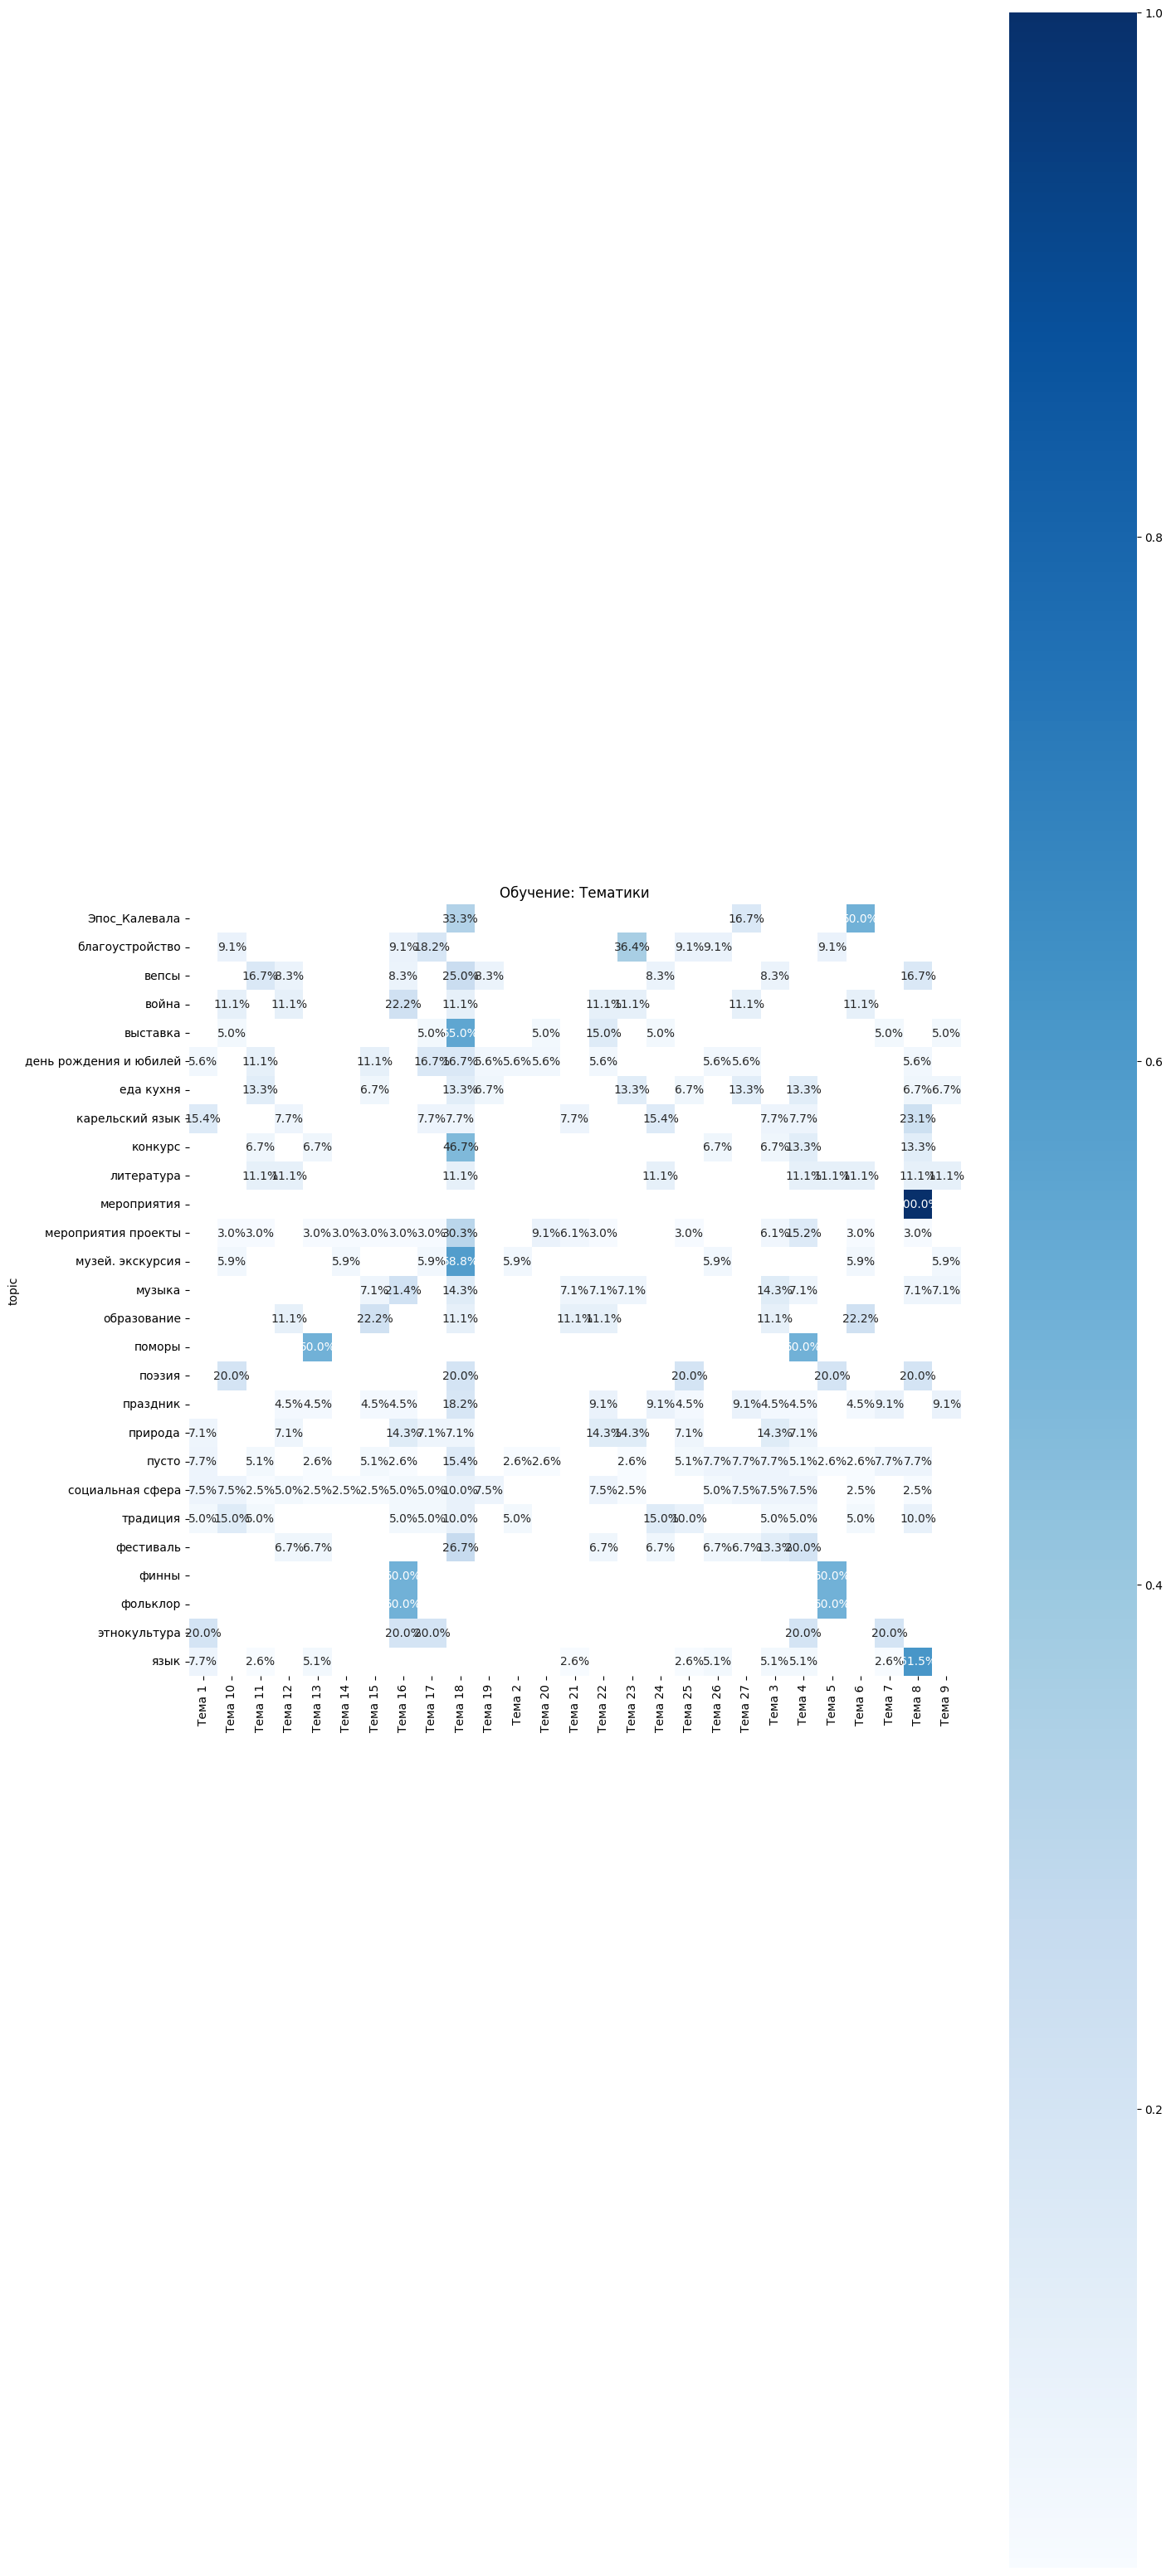

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
plt.figure(figsize=(15, 40))
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Обучение: Тематики')


In [ ]:
train_eval = pd.DataFrame(train_preds, columns=topic_labels, index=train_docs.topic)
train_eval

,Тема 1,Тема 2,Тема 3,Тема 4,Тема 5,Тема 6,Тема 7,Тема 8,Тема 9,Тема 10,...,Тема 18,Тема 19,Тема 20,Тема 21,Тема 22,Тема 23,Тема 24,Тема 25,Тема 26,Тема 27
topic,,,,,,,,,,,,,,,,,,,,,
вепсы,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,...,0.752610,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515,0.009515
природа,0.012425,0.012425,0.012425,0.676947,0.012425,0.012425,0.012425,0.012425,0.012425,0.012425,...,0.012425,0.012425,0.012425,0.012425,0.012425,0.012425,0.012425,0.012425,0.012425,0.012425
музей. экскурсия,0.004767,0.004767,0.004767,0.092038,0.196650,0.004767,0.057407,0.066858,0.004767,0.004767,...,0.300825,0.004767,0.004767,0.004767,0.004767,0.004767,0.004767,0.004767,0.004767,0.004767
выставка,0.005669,0.005669,0.067344,0.119127,0.005669,0.005669,0.005669,0.005669,0.005669,0.005669,...,0.288078,0.005669,0.005669,0.005669,0.005669,0.005669,0.005669,0.005669,0.005669,0.005669
конкурс,0.007791,0.007791,0.007791,0.007791,0.007791,0.007791,0.007791,0.007791,0.007791,0.007791,...,0.246385,0.007791,0.007791,0.007791,0.007791,0.007791,0.007791,0.007791,0.007791,0.007791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
язык,0.008122,0.008122,0.008122,0.008122,0.008122,0.008122,0.008122,0.150349,0.008122,0.008122,...,0.008122,0.008122,0.008122,0.008122,0.008122,0.008122,0.008122,0.008122,0.008122,0.008122
природа,0.005828,0.005828,0.005828,0.005828,0.005828,0.005828,0.005828,0.005828,0.005828,0.005828,...,0.236987,0.005828,0.005828,0.005828,0.005828,0.005828,0.005828,0.005828,0.005828,0.005828
музыка,0.004562,0.004562,0.245032,0.065191,0.004562,0.004562,0.004562,0.147905,0.004562,0.004562,...,0.229913,0.004562,0.004562,0.004562,0.004562,0.004562,0.004562,0.004562,0.004562,0.004562


In [ ]:
df = train_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
train_eval = pd.DataFrame(data=lda.transform(doc_train_matrix),
                          columns=topic_labels,
                          index=train_docs.topic)
test_eval = pd.DataFrame(data=lda.transform(doc_test_matrix),
                         columns=topic_labels,
                         index=test_docs.topic)

<ipython-input-29-827e74a28c9f>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = train_eval.groupby(level='topic').idxmax(


**Визуализация в виде тепловой карты (heatmap) для анализа распределения тем в наборе данных: тестовый (test_eval)**

<ipython-input-37-b3ab076de811>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  df = test_eval.groupby(level='topic').idxmax(


Text(0.5, 1.0, 'Данные обучения: Тематические задания')

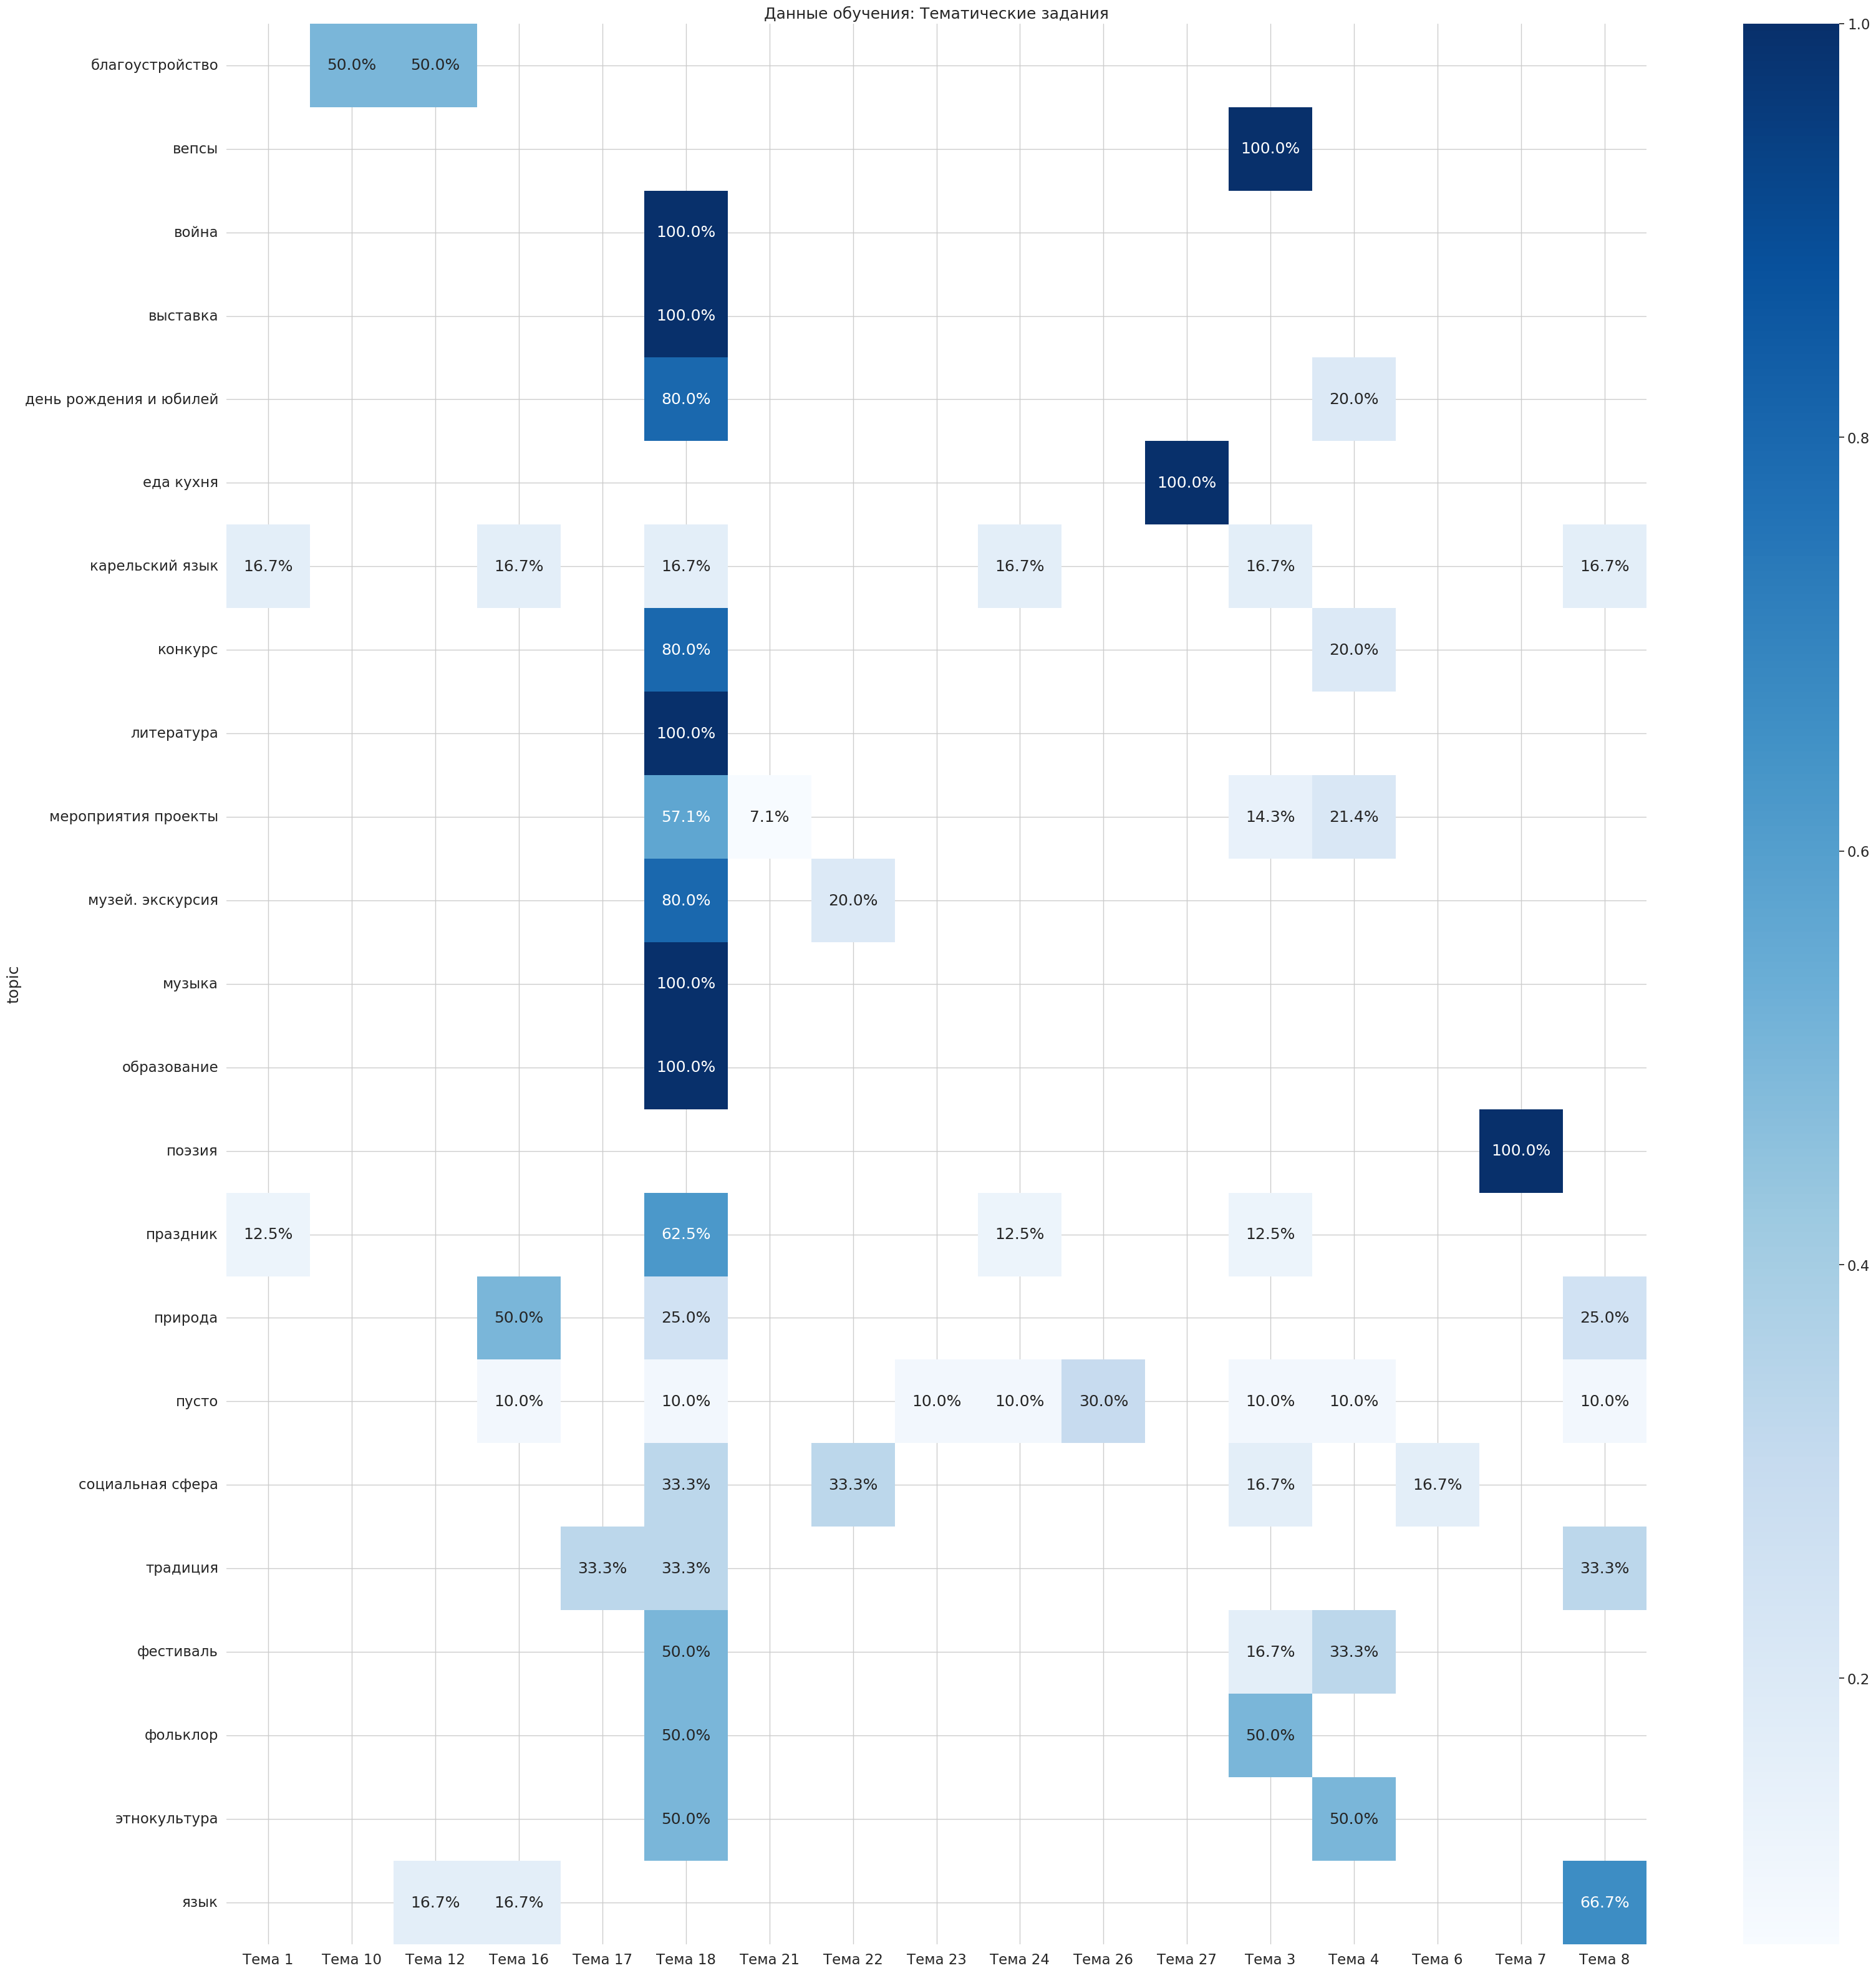

In [ ]:
df = test_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True)
plt.figure(figsize=(40, 40))
sns.heatmap(df.groupby(level='topic').value_counts(normalize=True)
            .unstack(-1), annot=True, fmt='.1%', cmap='Blues', square=True)
plt.title('Данные обучения: Тематические задания')

In [ ]:
test_assignments = test_eval.groupby(level='topic').idxmax(
    axis=1).reset_index(-1, drop=True).to_frame('predicted').reset_index()
test_assignments['text'] = test_docs.text.values
test_assignments.head(5)

<ipython-input-30-c37182911221>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  test_assignments = test_eval.groupby(level='topic').idxmax(


,topic,predicted,text
0,благоустройство,Тема 12,🚩 Страницы истории г.Олонец был оккупирован 6 ...
1,благоустройство,Тема 10,"Друзья👍🏻 А почему бы не напомнить Вам, что у ..."
2,вепсы,Тема 3,"В четверг, 27 октября, в прямом эфире в рамках..."
3,война,Тема 18,Первая просветительская акция «Душа одна на вс...
4,война,Тема 18,9 августа Республика Карелия отметит Междунаро...


In [ ]:
test_assignments = (test_eval.groupby(level='topic').idxmax(axis=1)
                   .reset_index(-1, drop=True)
                   .to_frame('predicted')
                   .reset_index())

test_assignments['text'] = test_docs.text.values

war_assignments = test_assignments[test_assignments['topic'] == 'война']
war_assignments
war_assignments.to_csv("war.csv")

<ipython-input-43-2aea02cd00df>:1: FutureWarning: DataFrameGroupBy.idxmax with axis=1 is deprecated and will be removed in a future version. Operate on the un-grouped DataFrame instead
  test_assignments = (test_eval.groupby(level='topic').idxmax(axis=1)


In [ ]:
test_assignments.to_csv("res.csv")